In [23]:
#!pip install transformers

In [24]:
# Saving model

import json
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from tqdm import tqdm

In [25]:
import torch
print("Built with CUDA:", torch.version.cuda)          # должно быть '11.8'
print("cuDNN version:", torch.backends.cudnn.version())  # число, не None
print("CUDA available:", torch.cuda.is_available())

Built with CUDA: 12.1
cuDNN version: 90100
CUDA available: True


In [26]:
# Версия самого PyTorch
print("PyTorch version:", torch.__version__)

# Версия CUDA, с которой он собран (Runtime CUDA)
print("Built with CUDA:", torch.version.cuda)

# Версия cuDNN
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 2.5.1
Built with CUDA: 12.1
cuDNN version: 90100


In [27]:
with open('slovakdata/train.json', 'r', encoding='utf-8') as f:
    train_data = [json.loads(line) for line in f]
with open('slovakdata/test.json', 'r', encoding='utf-8') as f:
    test_data = [json.loads(line) for line in f]


train_samples, val_samples = train_test_split(train_data, test_size=0.1, random_state=42)


In [28]:
# 2. Dataset class
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

class ToxicDataset(Dataset):
    def __init__(self, samples, tokenizer, max_len=128):
        texts = [s['text'] for s in samples]
        labels = [s['label'] for s in samples]
        enc = tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
        self.input_ids = enc['input_ids']
        self.attn_mask = enc['attention_mask']
        self.labels = torch.tensor(labels)

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_mask[idx],
            'labels': self.labels[idx]
        }

# Create datasets and loaders
batch_size = 16
datasets = {
    'train': ToxicDataset(train_samples, tokenizer),
    'val': ToxicDataset(val_samples, tokenizer),
    'test': ToxicDataset(test_data, tokenizer)
}
dataloaders = {k: DataLoader(v, batch_size=batch_size, shuffle=(k == 'train')) for k, v in datasets.items()}


In [29]:
# 3. Model, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.enabled   = True
torch.backends.cudnn.benchmark = True
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased').to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 5
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'test_loss': [], 'test_acc': []}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:

epochs_range = range(1, epochs + 1)
for epoch in epochs_range:
    print(f"\n=== Starting Epoch {epoch}/{epochs} ===", flush=True)
    # 4. Train
    model.train()
    train_losses, train_preds, train_labels = [], [], []
    for batch in tqdm(dataloaders['train'], desc=f"Epoch {epoch}/{epochs} - Training", leave=False):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attn = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attn, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_preds += torch.argmax(logits, dim=1).cpu().tolist()
        train_labels += labels.cpu().tolist()
    train_loss = np.mean(train_losses)
    train_acc = accuracy_score(train_labels, train_preds)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    print(f"Epoch {epoch} Training | loss={train_loss:.4f}, acc={train_acc:.4f}", flush=True)

    # Validation
    model.eval()
    val_losses, val_preds, val_labels = [], [], []
    for batch in tqdm(dataloaders['val'], desc=f"Epoch {epoch}/{epochs} - Validation", leave=False):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attn, labels=labels)
            val_losses.append(outputs.loss.item())
            val_preds += torch.argmax(outputs.logits, dim=1).cpu().tolist()
            val_labels += labels.cpu().tolist()
    val_loss = np.mean(val_losses)
    val_acc = accuracy_score(val_labels, val_preds)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch} Validation | loss={val_loss:.4f}, acc={val_acc:.4f}", flush=True)

    # Test
    test_losses, test_preds, test_labels = [], [], []
    for batch in tqdm(dataloaders['test'], desc=f"Epoch {epoch}/{epochs} - Testing", leave=False):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attn, labels=labels)
            test_losses.append(outputs.loss.item())
            test_preds += torch.argmax(outputs.logits, dim=1).cpu().tolist()
            test_labels += labels.cpu().tolist()
    test_loss = np.mean(test_losses)
    test_acc = accuracy_score(test_labels, test_preds)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    print(f"Epoch {epoch} Testing    | loss={test_loss:.4f}, acc={test_acc:.4f}", flush=True)



=== Starting Epoch 1/5 ===


Epoch 1 Training | loss=0.5720, acc=0.7269


Epoch 1 Validation | loss=0.5294, acc=0.7296


Epoch 1 Testing    | loss=0.5446, acc=0.7278

=== Starting Epoch 2/5 ===


Epoch 2 Training | loss=0.5193, acc=0.7490


Epoch 2 Validation | loss=0.5152, acc=0.7498


Epoch 2 Testing    | loss=0.5401, acc=0.7377

=== Starting Epoch 3/5 ===


Epoch 3 Training | loss=0.4416, acc=0.7980


Epoch 3 Validation | loss=0.5194, acc=0.7641


Epoch 3 Testing    | loss=0.5299, acc=0.7574

=== Starting Epoch 4/5 ===


Epoch 4 Training | loss=0.3371, acc=0.8581


Epoch 4 Validation | loss=0.5745, acc=0.7540


Epoch 4 Testing    | loss=0.5984, acc=0.7316

=== Starting Epoch 5/5 ===


Epoch 5 Training | loss=0.2254, acc=0.9122


Epoch 5 Validation | loss=0.7307, acc=0.7211


Epoch 5 Testing    | loss=0.7763, acc=0.6892


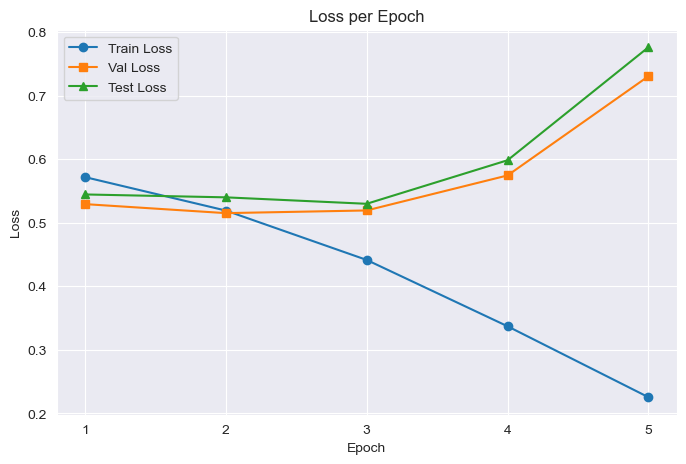

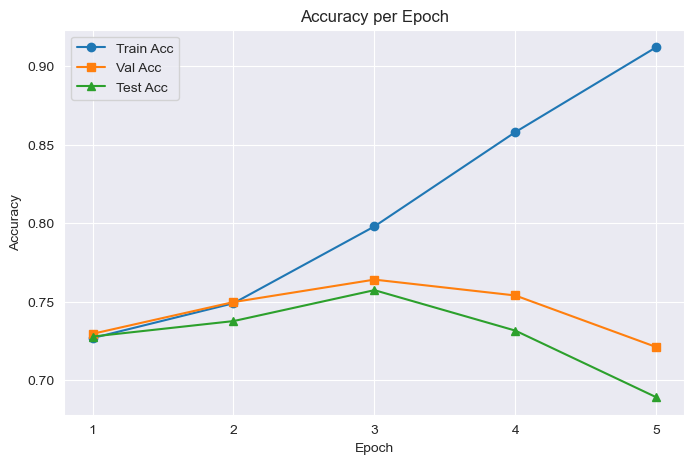

In [31]:
# 7. Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history['train_loss'], marker='o', label='Train Loss')
plt.plot(epochs_range, history['val_loss'], marker='s', label='Val Loss')
plt.plot(epochs_range, history['test_loss'], marker='^', label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history['train_acc'], marker='o', label='Train Acc')
plt.plot(epochs_range, history['val_acc'], marker='s', label='Val Acc')
plt.plot(epochs_range, history['test_acc'], marker='^', label='Test Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix:
 [[719 240]
 [170 190]]


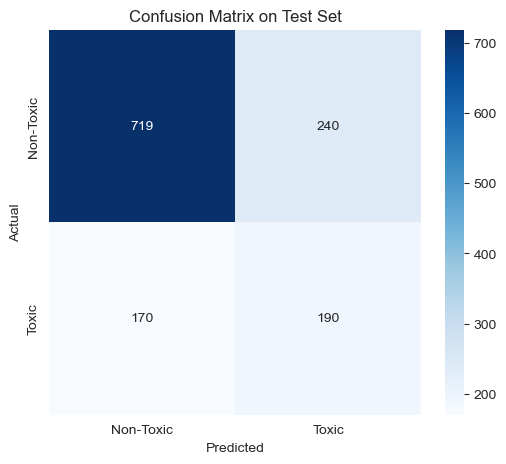


Classification Report:
               precision    recall  f1-score   support

   Non-Toxic     0.8088    0.7497    0.7781       959
       Toxic     0.4419    0.5278    0.4810       360

    accuracy                         0.6892      1319
   macro avg     0.6253    0.6388    0.6296      1319
weighted avg     0.7086    0.6892    0.6970      1319



In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Собираем все предсказания и метки
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in dataloaders['test']:
        input_ids = batch['input_ids'].to(device)
        attn      = batch['attention_mask'].to(device)
        labels    = batch['labels'].to(device)
        logits    = model(input_ids, attention_mask=attn).logits
        preds     = torch.argmax(logits, dim=1).cpu().tolist()
        all_preds += preds
        all_labels += labels.cpu().tolist()

# Печать и визуализация
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Toxic','Toxic'],
            yticklabels=['Non-Toxic','Toxic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

print("\nClassification Report:\n",
      classification_report(all_labels, all_preds, target_names=['Non-Toxic','Toxic'], digits=4))
